In [1]:
from importlib import reload
import sys
import os
sys.path.insert(0, './..')
sys.path.insert(0, './../scripts')

In [2]:
from importlib import reload

import pickle
import time

import numpy as np
import tensorflow as tf
import logging
from scipy import linalg
from scipy import sparse

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.axes_grid1 import make_axes_locatable

import plot_func as pf
import util_func as uf

import dev_ori_sel_RF
from dev_ori_sel_RF import data_dir,network,connectivity,dynamics_np
from dev_ori_sel_RF.tools import misc,update_params_dict,gen_gaussian_random_field

2023-08-11 11:51:54.130000: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Please install GPU version of TF


In [9]:
np.stack((np.arange(10),np.arange(10,20)))

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]])

# Define functions to simulate dynamics

In [3]:
from scipy.integrate import solve_ivp

def fio_rect(x):
    return np.fmax(x,0)

def dynamics_system(y,inp_ff,Wrec,\
                    gamma_E,gamma_I,gamma_ff,n_E,n_I,tau):
    argE = gamma_E * np.dot(Wrec[0,0],y[0]) + gamma_I * np.dot(Wrec[0,1],y[1]) + gamma_ff * inp_ff[0]
    argI = gamma_E * np.dot(Wrec[1,0],y[0]) + gamma_I * np.dot(Wrec[1,1],y[1]) + gamma_ff * inp_ff[1]
    return 1./tau*( -y + np.stack([fio_rect(argE)**n_E,fio_rect(argI)**n_I]))

def integrate(y0,inp,dt,Nt,gamma_E=1.02,gamma_I=1.02,n_E=2,n_I=3):
    y = y0
    for t_idx in range(Nt):
        out = dynamics_system(y,inp,W4to4,gamma_E,gamma_I,1.0,n_E,n_I,1.0)
        dy = out
        y = y + dt*dy
    return y
#     def ode_fun(t,y):
#         return dynamics_system(y,inp,W4to4,gamma_rec,1.0,N4*N4,1.0)
#     sol = solve_ivp(ode_fun,[0,dt*Nt],y0,method='RK23',first_step=dt)
#     return np.array([sol.y[:N4**2,-1].reshape((N4,N4)),sol.y[N4**2:,-1].reshape((N4,N4))])

# Calculate the typical length scale in RELU network

In [4]:
config_name = "big_homo"
Version = -1
config_dict,N4pop,Nlgnpop,Nret,Nlgn,N4,rA = uf.get_network_size(config_name)

MISC params_dict params_big_homo {'Nret': 60, 'Nlgn': 60, 'N4': 60, 'N23': 1, 'Nvert': 1, 'runtime': 32000, 'dt': 0.05, 'tau': 1.0, 'num_lgn_paths': 4, 'gamma_lgn': 4.0, 'gamma_4': 1.0, 'gamma_23': 1.0, 'learning_rate_decay_const': 160000.0, 'saving_stepsize': 10, 'plasticity_rule': 'activity_based', 'random_seed': 19, 'nonlinearity_l4': 'rectifier', 'nonlinearity_l23': 'rectifier', 'integrator': 'Euler', 'test_lowDsubset': False, 'developing_params': [], 'Inp_params': {'ndim': 25, 'radius': 3.0, 'width': 1.0, 'simulate_activity': 'dynamics', 'pattern_duration': 2500, 'avg_no_inp': 1, 'expanse_time': 1, 'init_radius': 0.3, 'mean_width': 0.3, 'onoff_corr_factor': 1.0, 'onoff_rel_weight': 1.0, 'input_type': 'white_noise_online', 'off_bias_strength': 0.0, 'off_bias_region_size': 0.5}, 'Wret_to_lgn_params': {'sigma1': 0.01125, 'sigma2': 0.03, 'ampl1': 2.0, 'ampl2': 1.0, 'gamma_ret': 1.0, 'noise': 0.0, 'sigma': 0.016875, 'ampl': 1.0, 'profile': 'Gaussian', 'mean_eccentricity': 0.6, 'SD_ecce

In [7]:
rates = np.load('homo_rates_N4={:d}.npy'.format(N4)).reshape((-1,2,N4,N4))
n_inp = rates.shape[0]

# fps_dat = np.zeros(int(np.ceil(N4//2*np.sqrt(2))))
# fps_err = np.zeros(int(np.ceil(N4//2*np.sqrt(2))))
fps_dat = np.zeros(N4//2)
fps_err = np.zeros(N4//2)

grid = np.arange(-N4//2,N4//2)
x,y = np.meshgrid(grid,grid)
bin_idxs = np.digitize(np.sqrt(x**2+y**2),np.arange(0,np.ceil(N4//2*np.sqrt(2)))+0.5)

for i in range(10):
    for j in range(10):
        idx = i*10+j
        
        fp2 = np.abs(np.fft.fftshift(np.fft.fft2(rates[idx,0]-np.nanmean(rates[idx,0]))))**2
        for idx in range(N4//2):
            fps_dat[idx] += np.mean(fp2[bin_idxs == idx])
            fps_err[idx] += np.var(fp2[bin_idxs == idx])
            
        fp2 = np.abs(np.fft.fftshift(np.fft.fft2(rates[idx,1]-np.nanmean(rates[idx,1]))))**2
        for idx in range(N4//2):
            fps_dat[idx] += np.mean(fp2[bin_idxs == idx])
            fps_err[idx] += np.var(fp2[bin_idxs == idx])

fps_dat /= 2*n_inp
fps_err /= 2*n_inp
fps_err = np.sqrt(fps_err / (2*n_inp))
# fps_dat /= n_inp
# fps_err /= n_inp
# fps_err = np.sqrt(fps_err / n_inp)

Λ = 15.0


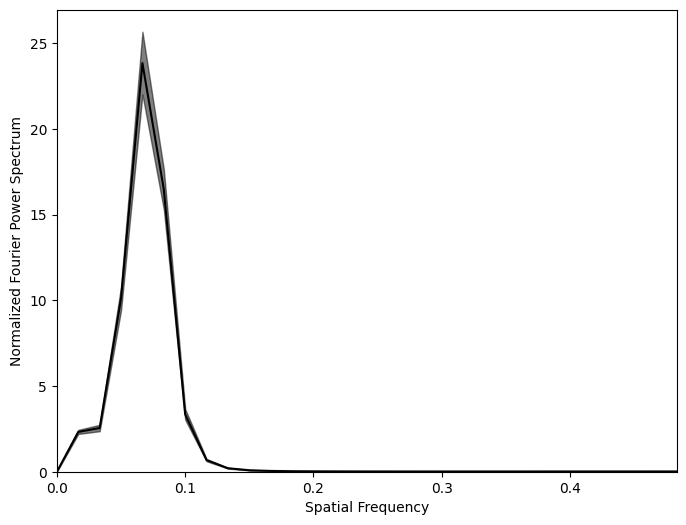

In [8]:
fig,axs = plt.subplots(1,1,figsize=(8,6))

# freqs = np.arange(int(np.ceil(N4//2*np.sqrt(2))))/N4
freqs = np.arange(N4//2)/N4

axs.plot(freqs,fps_dat/np.sum(fps_dat)*N4,'k')
axs.fill_between(freqs,(fps_dat+fps_err)/np.sum(fps_dat)*N4,
                 (fps_dat-fps_err)/np.sum(fps_dat)*N4,
                 color='k',alpha=0.5)

axs.set_xlabel('Spatial Frequency')
axs.set_ylabel('Normalized Fourier Power Spectrum')

axs.set_xlim(0,(N4//2-1)/N4)
axs.set_ylim(0,None)

Lam = 1/freqs[np.argmax(fps_dat)]
print('Λ =',Lam)

# Solve for SSN parameters that would give correct correlation patterns